In [2]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline

from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
from ipynb.fs.full.All_Functions import ParamsPrep
from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation
from ipynb.fs.full.All_Functions import Trial_Simulation_paramInput
from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_7BroadVariants.csv'
Data_df = pd.read_csv(data_file)
Data_unVacc = Data_df[(Data_df.cat_VaccStatus!='Boosted')*(Data_df.cat_VaccStatus!='Second dose')*(Data_df.cat_VaccStatus!='First dose') ]
Data_unVacc_symp = Data_unVacc[Data_unVacc.cat_SympEver != 'No']
IDs_Symp = Data_unVacc_symp.ID.unique()
print(len(Data_unVacc_symp.ID.unique()))
Olddata_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_AppendNegatives.csv'
OldData_df = pd.read_csv(Olddata_file)
OldData_unVacc = OldData_df[(OldData_df.cat_VaccStatus!='Boosted')*(OldData_df.cat_VaccStatus!='Second dose')*(OldData_df.cat_VaccStatus!='First dose') ]


IDs_unVacc = Data_unVacc.ID.unique()
OldIDs_unVacc = OldData_unVacc.ID.unique()


DeltaCases = Data_unVacc[Data_unVacc.cat_Lineage7variants == 'Delta']

ID_Delta = DeltaCases.ID.unique()
#print(len(ID_Delta))
IndParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/IndividualParameters/estimatedIndividualParameters.txt'
PopParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/populationParameters.txt'

parameters_df = pd.read_csv(IndParameters)
Popparameters_df = pd.read_csv(PopParameters)

Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'

Popparameters_PK = pd.read_csv(Popparameters_U_file)

560


In [5]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20})

Incubation_params = []
Variance = ['Historic', 'Alpha', 'Gamma', 'Delta', 'Omicron', 'Total']
Mean = [4.61, 4.96, 5.18, 4.43, 3.61, 4.54, 4.54]
SD = [2.24, 2.32, 2.72, 2.19, 1.82, 2.25]

for var, mean, sd in zip(Variance, Mean, SD):
    Incubation_params.append({'VOC': var, 'Mean': mean, 'sd': sd})

Incubation_params = pd.DataFrame(Incubation_params)
Incubation_params[Incubation_params.VOC == 'Historic'].Mean

0    4.61
Name: Mean, dtype: float64

In [6]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol


In [7]:
def Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort, TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    for idi, ID, tstart, in zip(range(0,len(Cohort)), Cohort, TrtmntStrtDay):

            tzero_est = param_dict[idi]['tzero']
            tau_est = param_dict[idi]['tau']
            if Data_unVacc_symp[Data_unVacc_symp.ID == ID].cat_Lineage7variants.unique()[0]=='None':
                Lineage = 'Total'
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
            else:
                Lineage = Data_unVacc_symp[Data_unVacc_symp.ID==ID].cat_Lineage7variants.unique()[0]
                shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

            incub = np.random.gamma(shape, scale)

            params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
            param_dict[idi]['tzero']=incub[0]
            param_dict[idi]['tau']=params[idi][-1]
            t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
            T,R,E,I,V, Ag, A1, A2 = y.T
            v = np.log10(np.maximum(V,10**2))
            v[v==2]=1
            Tmax_index = np.argwhere(v==max(v))[0][0]
            Tmax = t[Tmax_index]

            PS_Duration = t[np.where((v == 1) & (t>Tmax))]

            while (PS_Duration != [] and PS_Duration[0]<5):
                params[idi][-1] = tau_est
                param_dict[idi]['tzero']=tzero_est
                param_dict[idi]['tau']=tau_est

                incub = np.random.gamma(shape, scale)

                params[idi][-1] = params[idi][-1]+(tzero_est-incub[0])
                param_dict[idi]['tzero']=incub[0]
                param_dict[idi]['tau']=params[idi][-1]

                t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                          PKPDInd[idi], param_dict[idi], 
                                                          PotRed[idi], MolMass, 0, SetInit, VLPKPD,
                                   TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
                T,R,E,I,V, Ag, A1, A2 = y.T
                v = np.log10(np.maximum(V,10**2))
                v[v==2]=1
                Tmax_index = np.argwhere(v==max(v))[0][0]
                Tmax = t[Tmax_index]
                PS_Duration = t[np.where((v == 1) & (t>Tmax))]
    
    return params, param_dict

In [8]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['Vzero']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [9]:
def StandardDoseTimeSim(Cohort, TrtmntStrtDay, params, 
                        PKPDInd, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                       TreatmentLength = 5, TreatmentFrequency = 0.5):
    X = []
    times = []
    for idi, ID, tstart, in zip(range(0,len(Cohort)), Cohort, TrtmntStrtDay):

        t, y, dosetimes = Trial_Simulation_paramInput(tstart, params[idi][:], 
                                                      PKPDInd[idi], param_dict[idi], 
                                                      PotRed[idi], MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = TreatmentLength, TreatmentFrequency = TreatmentFrequency)
        T,R,E,I,V, Ag, A1, A2 = y.T
        v = np.log10(np.maximum(V,10**2))
        v[v==2]=1
        X.append(v)
        times.append(t)
    return X, times

In [17]:
# -------------------------------- simulating clinical trial with different doses -----------------------
# prepare cohort parameters
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
prf = [73, 61, 61, 61, 61, 65, 57, 61, 61, 65] # prf values that maximized R2 for 10 runs (fig2c)
MolMass = 499.5 
Num = 400
Cohort = Cohort_Prep(IDs_Symp, Num)
CohortStyle = 'direct'

for tr in range(0,10):
    print(tr)
    dose = 0
    VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                                   RandVLParams, parameters_df, Popparameters_df, 
                                                   fixed_params, param_order, param_dist, PKPDParams, 
                                                   Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                                   Emax, IC50, Hill,PDOm, dose)

    
    V_all_dur = []
    t_all_dur = []
    TrtmntStrtDay_all_dur = []

    # ---------------  simulate without treament ---------------------------------------
    TrtmntStrtDay = random.choices(range(1,4), k=Num) #treatment starting within 3 days of synptom onset (day 1 through 3)
    PotRed=np.random.normal(np.mean(prf), np.std(prf), Num)
    VLparams, param_dict = Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort,TrtmntStrtDay, VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
    #TrtmntStrtDay = [3 for i in range(0, len(Cohort))]
    dose = 0
    X, times = StandardDoseTimeSim(Cohort,TrtmntStrtDay, VLparams, 
                                   PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                   TreatmentLength = 5, TreatmentFrequency = 1)
    V_all_dur.append(X)
    t_all_dur.append(times)
    TrtmntStrtDay_all_dur.append(TrtmntStrtDay)
    # -------------------------simulate with treatment lasting for 5, 10, 15 days ----------------------

    for tlength in [2, 5, 10,15, 20]: 
        dose = 300
        print("  " + str(tlength))
        Cohort = Cohort_Prep(IDs_Symp, Num)
        VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                                   RandVLParams, parameters_df, Popparameters_df, 
                                                   fixed_params, param_order, param_dist, PKPDParams, 
                                                   Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                                   Emax, IC50, Hill,PDOm, dose)
        TrtmntStrtDay = random.choices(range(1,4), k=Num) #treatment starting within 3 days of synptom onset (day 1 through 3)
        PotRed=np.random.normal(np.mean(prf), np.std(prf), Num)
        VLparams, param_dict = Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort,TrtmntStrtDay, VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
        
        X, times = StandardDoseTimeSim(Cohort,TrtmntStrtDay, VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = tlength, TreatmentFrequency = 0.5)
        V_all_dur.append(X)
        t_all_dur.append(times)
        TrtmntStrtDay_all_dur.append(TrtmntStrtDay)
        
        #----------------- calculating rebound probability ------------------------------------------

    rebound2 = []
    rebound1 = []
    rebound05 = []
    for i, (dur,X,times) in enumerate(zip([ 2, 5, 10, 15, 20], V_all_dur[1:],t_all_dur[1:])):
        L_2 = np.zeros(len(X))
        L_1 = np.zeros(len(X))
        L_05 = np.zeros(len(X))
        L_control_2 = np.zeros(len(X))
        L_control_1 = np.zeros(len(X))
        L_control_05 = np.zeros(len(X))
        for ii,(x,t) in enumerate(zip(X,times)):
        # -- flag if treament VL ever exceeds NH VL
        # need to modify simulation function to unify the timesteps at 
        # which we report values
        # -- flag rebound if increase of viral load by at least 2 log following end of treatment
            temp = np.argwhere(t>TrtmntStrtDay_all_dur[i+1][ii]+dur)
            idx = temp[0][0]
            temp_control = np.argwhere(t_all_dur[0][ii]>TrtmntStrtDay_all_dur[0][ii]+dur)
            idx_control = temp_control[0][0]
            peaks2, props2 = find_peaks(V_all_dur[0][ii], height = 3, prominence = 2)
            peaks1, props1 = find_peaks(V_all_dur[0][ii], height = 3, prominence = 1)
            peaks05, props05 = find_peaks(V_all_dur[0][ii], height = 3, prominence = 0.5)
            if (np.max(x[idx:])-x[idx])>2:
                L_2[ii] = 1
                rebound2.append({'arm': 'Treatment', 'duration':dur, 'rebound': 'Yes'})
            else:
                rebound2.append({'arm': 'Treatment', 'duration':dur, 'rebound': 'No'})
            if (np.max(x[idx:])-x[idx])>1:
                L_1[ii] = 1
                rebound1.append({'arm': 'Treatment', 'duration':dur, 'rebound': 'Yes'})
            else:
                rebound1.append({'arm': 'Treatment', 'duration':dur, 'rebound': 'No'})
            if (np.max(x[idx:])-x[idx])>0.5:
                L_05[ii] = 1
                rebound05.append({'arm': 'Treatment', 'duration':dur, 'rebound': 'Yes'})
            else:
                rebound05.append({'arm': 'Treatment', 'duration':dur, 'rebound': 'No'})
            if (len(peaks2)>1):
                L_control_2[ii] = 1
                rebound2.append({'arm': 'Control', 'duration':dur, 'rebound': 'Yes'})
            else:
                rebound2.append({'arm': 'Control', 'duration':dur, 'rebound': 'No'})
            if (len(peaks1)>1):
                L_control_1[ii] = 1
                rebound1.append({'arm': 'Control', 'duration':dur, 'rebound': 'Yes'})
            else:
                rebound1.append({'arm': 'Control', 'duration':dur, 'rebound': 'No'})
            if (len(peaks05)>1):
                L_control_05[ii] = 1
                rebound05.append({'arm': 'Control', 'duration':dur, 'rebound': 'Yes'})   
            else:
                rebound05.append({'arm': 'Control', 'duration':dur, 'rebound': 'No'})
    
    rebound2 = pd.DataFrame(rebound2)
    rebound1 = pd.DataFrame(rebound1)
    rebound05 = pd.DataFrame(rebound05)
    x,y = 'duration', 'rebound'

    df2 = rebound2.groupby(['arm',x])[y].value_counts(normalize=True)
    df2 = df2.mul(100)
    df2 = df2.rename('% rebound').reset_index()
    if tr == 0:
        df_dur_2 = df2.copy()
    else:
        df_dur_2 = pd.concat([df_dur_2,df2])
        
    df1 = rebound1.groupby(['arm',x])[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('% rebound').reset_index()
    if tr == 0:
        df_dur_1 = df1.copy()
    else:
        df_dur_1 = pd.concat([df_dur_1,df1])
        
    df05 = rebound05.groupby(['arm',x])[y].value_counts(normalize=True)
    df05 = df05.mul(100)
    df05 = df05.rename('% rebound').reset_index()
    if tr == 0:
        df_dur_05 = df05.copy()
    else:
        df_dur_05 = pd.concat([df_dur_05,df05])

0
  2
  5
  10
  15
  20
1
  2
  5
  10
  15
  20
2
  2
  5
  10
  15
  20
3
  2
  5
  10
  15
  20
4
  2
  5
  10
  15
  20
5
  2
  5
  10
  15
  20
6
  2
  5
  10
  15
  20
7
  2
  5
  10
  15
  20
8
  2
  5
  10
  15
  20
9
  2
  5
  10
  15
  20


In [18]:
pickle.dump(V_all_dur , open('FigureData/ViralLoad_Treatmentstartday_within_3_days_diffDur.pickle', 'wb'))
pickle.dump(t_all_dur, open('FigureData/Time_Treatmentstartday_within_3_days_diffDur.pickle', 'wb'))
pickle.dump(TrtmntStrtDay_all_dur, open('FigureData/TrtmntStrtDay_Treatmentstartday_within_3_days_diffDur.pickle', 'wb'))
pickle.dump(df_dur_05, open('FigureData/rebound05_Treatmentstartday_within_3_days_diffDur.pickle', 'wb'))
pickle.dump(df_dur_1, open('FigureData/rebound1_Treatmentstartday_within_3_days_diffDur.pickle', 'wb'))
pickle.dump(df_dur_2, open('FigureData/rebound2_Treatmentstartday_within_3_days_diffDur.pickle', 'wb'))

In [10]:
V_all_dur = pickle.load(open('FigureData/ViralLoad_Treatmentstartday_within_3_days_diffDur.pickle', 'rb'))
t_all_dur = pickle.load(open('FigureData/Time_Treatmentstartday_within_3_days_diffDur.pickle', 'rb'))
TrtmntStrtDay_all_dur = pickle.load(open('FigureData/TrtmntStrtDay_Treatmentstartday_within_3_days_diffDur.pickle', 'rb'))
df_dur_05 = pickle.load(open('FigureData/rebound05_Treatmentstartday_within_3_days_diffDur.pickle', 'rb'))
df_dur_1 = pickle.load(open('FigureData/rebound1_Treatmentstartday_within_3_days_diffDur.pickle', 'rb'))
df_dur_2 = pickle.load(open('FigureData/rebound2_Treatmentstartday_within_3_days_diffDur.pickle', 'rb'))

In [12]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
pair_sig =[]
TreatmentStartDay = 1
VL = []
Num=400
for d, day in enumerate([2,5,10]):
    for i,tlength in enumerate(['control', 2,5, 10]):
        for j in  range(0,Num):
            t_target = np.argwhere(t_all_dur[i][j]>=TrtmntStrtDay_all_dur[i][j]+day)[0][0]#index of time target days after treatment start day
            VL.append({'target day': day, 'Treatment duration': tlength, 'log10(VL)': V_all_dur[i][j][t_target]})
    pairs = list(it.combinations(['control', 2, 5, 10],2))
    for pair in pairs:
        vl1=[]
        vl2=[]
        VirL = list(filter(lambda d: d['target day']== day, VL))
        VL1 = filter(lambda d: d['Treatment duration']==pair[0], VirL)
        for d in VL1:
            vl1.append(d['log10(VL)'])
        VL2 = filter(lambda d: d['Treatment duration']==pair[1], VirL)
        for d1 in VL2:
            vl2.append(d1['log10(VL)'])
        _, p = st.mannwhitneyu(vl1, vl2)
        if p>0.01:
            print(str(pair)+ '=' +str(p))
        else: 
            pair_sig.append([(day,pair[0]),(day, pair[1])])
VL = pd.DataFrame(VL)


(2, 5)=0.4718863259262034
(2, 10)=0.3596632299061293
(5, 10)=0.11374875512616867
('control', 2)=0.019861797491995313
(5, 10)=0.5920447336263674
('control', 2)=0.8875813718927644


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

10_5 vs. 10_10: Mann-Whitney-Wilcoxon test two-sided, P_val:2.268e-14 U_stat=1.000e+05
2_control vs. 2_2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.057e-19 U_stat=1.094e+05
5_2 vs. 5_5: Mann-Whitney-Wilcoxon test two-sided, P_val:1.535e-27 U_stat=1.153e+05
10_2 vs. 10_5: Mann-Whitney-Wilcoxon test two-sided, P_val:2.966e-04 U_stat=9.089e+04
10_2 vs. 10_10: Mann-Whitney-Wilcoxon test two-sided, P_val:6.675e-28 U_stat=1.105e+05
5_2 vs. 5_10: Mann-Whitney-Wilcoxon test two-sided, P_val:4.125e-25 U_stat=1.136e+05
2_control vs. 2_5: Mann-Whitney-Wilcoxon test two-sided, P_val:3.440e-21 U_stat=1.109e+05
5_control vs. 5_5: Mann-Whitney-Wilcoxon test two-sided, P_val:1.303e-42 U_stat=1.245e+05
10_control vs. 10_5: Mann-Whitney-Wilcoxon test two-sided, P_val:4.630e-05 U_stat=9.237e+04
10_control vs. 10_10: Mann-W

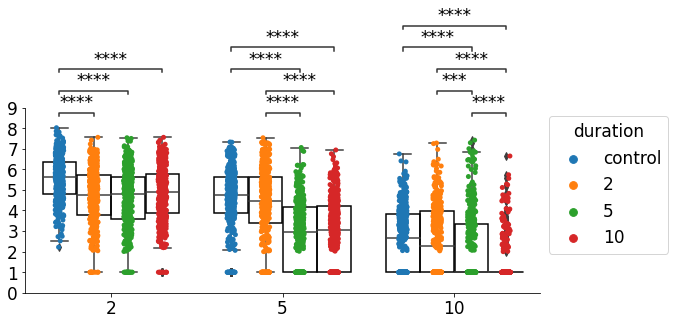

In [14]:
fig = plt.figure(figsize = (10,6))
plt.rcParams.update({'font.size': 17})
ax = sns.stripplot(x='target day', y='log10(VL)', data = VL, hue = 'Treatment duration', dodge=True)
handles, labels = ax.get_legend_handles_labels()
ax = sns.boxplot(x='target day', y='log10(VL)', data = VL, hue = 'Treatment duration')
for p in ax.patches:
    mybox =p
    color = mybox.get_facecolor()
    mybox.set_facecolor((0, 0, 0, 0))
    mybox.set_edgecolor('black')


annotator = Annotator(ax, pair_sig, data=VL, x='target day', y='log10(VL)', hue = 'Treatment duration')
annotator.configure(test = 'Mann-Whitney', loc='outside').apply_and_annotate()
#plt.title('Treatment starts within 3 days post symptoms\n')
ax.legend(handles, labels, title = 'duration', bbox_to_anchor=(1, 1))
#ax.get_legend().remove()
ax.set_yticks(np.linspace(0,9,10))
sns.despine()
#ax.set_ylabel('log10 viral load')
#plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1), title = 'Treatment duration')

#plt.ylabel('log10(VL) drop')
plt.tight_layout()
plt.xlabel('')
plt.ylabel('')   
plt.savefig('/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Paxlovid Paper/PaperFigures/UpdatedFigures/ViralLoad_duration.png')


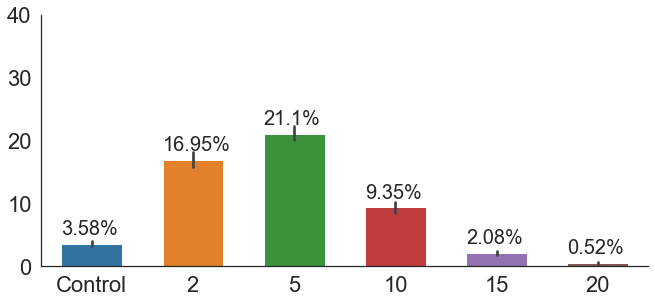

In [15]:
sns.set(palette = 'tab10', style = 'white', font_scale=2)
df_dur_1_cntrl=df_dur_1[(df_dur_1.arm=='Control')*(df_dur_1.rebound == 'Yes')]
df_dur_1_others=df_dur_1[(df_dur_1.arm!='Control')*(df_dur_1.rebound == 'Yes')]
df_dur_1_Yes = pd.concat([df_dur_1_cntrl,df_dur_1_others])
rebound_dur_Control = df_dur_1_Yes[(df_dur_1_Yes.arm=='Control')*(df_dur_1_Yes.duration == 2)]
rebound_dur_Control.duration = 'Control'

rebound_dur_1 = pd.concat([rebound_dur_Control, df_dur_1_others])
g = sns.catplot(x='duration',y='% rebound', kind='bar',data=rebound_dur_1, height=5, aspect=2, ci = 95)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()+0.1
    txt_y = p.get_height()+1.5
    g.ax.text(txt_x,txt_y,txt, size = 'small')
    current_width = p.get_width()
    diff = current_width - 0.6
    # we change the bar width
    p.set_width(0.6)
    # we recenter the bar
    p.set_x(p.get_x() + diff * .5)

g.ax.set_ylim([0, 40])
plt.xlabel('')
plt.ylabel('')
plt.savefig('/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Covid-19/Paxlovid Paper/PaperFigures/UpdatedFigures/rebound_duration.png')


In [44]:
# prepare cohort parameters
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
prf = [73, 61, 61, 61, 61, 65, 57, 61, 61, 65] # prf values that maximized R2 for 10 runs (fig2c)
MolMass = 499.5 
Num = 400
Cohort = Cohort_Prep(IDs_Symp, Num)
CohortStyle = 'direct'
dose = 0
incubation = []
VLparams, PKPD_params, param_dict = ParamsPrep(Cohort, CohortStyle, GetVLIndParams, 
                                               RandVLParams, parameters_df, Popparameters_df, 
                                               fixed_params, param_order, param_dist, PKPDParams, 
                                               Popparameters_PK, GetPopParams, GetPopParamsOmega, 
                                               Emax, IC50, Hill,PDOm, dose)

for idi in range(0,Num):
    
    if (np.log10(param_dict[idi]['Vzero'])>2):
       # print(np.log10(param_dict[idi]['V0']))
        param_dict1={'Vzero': 100}
        param_dict[idi].update(param_dict1)
        
V_all_dur = []
t_all_dur = []
TrtmntStrtDay_all_dur = []
# ---------------  simulate without treament ---------------------------------------
TrtmntStrtDay = [random.randint(1, 3) for i in range(0,len(Cohort))]
PotRed=np.random.normal(np.mean(prf), np.std(prf), Num)
VLparams, param_dict = Incubation_Prep(Data_unVacc_symp, Incubation_params, Cohort,TrtmntStrtDay, VLparams, 
                                       PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                       TreatmentLength = 5, TreatmentFrequency = 0.5)
#TrtmntStrtDay = [3 for i in range(0, len(Cohort))]
dose = 0
X, times = StandardDoseTimeSim(Cohort,TrtmntStrtDay, VLparams, 
                               PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 1)
V_all_dur.append(X)
t_all_dur.append(times)
TrtmntStrtDay_all_dur.append(TrtmntStrtDay)
# -------------------------simulate with treatment lasting for 5, 10, 15 days ----------------------

for tlength in [2, 5, 10,15, 20]: 
    dose = 300
    print("  " + str(tlength))
    X, times = StandardDoseTimeSim(Cohort,TrtmntStrtDay, VLparams, 
                                   PKPD_params, param_dict, PotRed, MolMass, dose, SetInit, VLPKPD,
                                   TreatmentLength = tlength, TreatmentFrequency = 0.5)
    V_all_dur.append(X)
    t_all_dur.append(times)
    TrtmntStrtDay_all_dur.append(TrtmntStrtDay)


  2
  5
  10
  15
  20


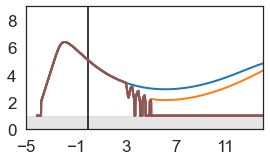

In [102]:
# plot a few examples
dur = ['Control', 2, 5, 10, 15, 20]
fig = plt.figure(figsize = (4,2.5))
plt.rcParams.update({'xtick.labelsize':17})
plt.rcParams.update({'ytick.labelsize':17})
for i in range(0,1):
  #  plt.subplot(4,4,1+i)
    plt.vlines(x = 0, ymin = 0, ymax = 9,color = 'k')
    
    
   # plt.fill_betweenx(np.linspace(0,9,20), 1*np.ones(20), 5*np.ones(20), color = 'tab:red', alpha = 0.2)
   # plt.fill_betweenx(np.linspace(0,9,20), 5*np.ones(20), 10*np.ones(20), color = 'tab:purple', alpha = 0.2)

    
    plt.fill_between(np.linspace(-5,14,20), 0*np.ones(20), np.ones(20), color = 'grey', alpha = 0.2)
    plt.ylim(0,9)
    plt.yticks(range(0,9, 2))
    plt.xticks(range(-5,25, 4))
   # plt.xlabel('days since treatment')
  #  plt.ylabel('log10 viral load')

    for times, X, label in zip(t_all_dur,V_all_dur, dur):
        plt.plot(times[77],X[77], label = label, linewidth = 2)
      #  plt.fill_betweenx(np.linspace(0,9,20), t_all[1][j][0]*np.ones(20), (t_all[1][j][0]+1)*np.ones(20), color = 'tab:orange', alpha = 0.1)
    plt.xlim(-5,14)
 #   plt.title(i+350)
plt.tight_layout()
#plt.legend(loc = 'upper left', title = 'duration', bbox_to_anchor=(1., 1.5)) 
#plt.savefig('PaperFigs/dosesamples_0.svg')
#3,8,16,41,49,77